In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)


In [2]:
TRAIN_PATH = "/content/caltech-transportation_train"
TEST_PATH  = "/content/caltech-transportation_test"


In [3]:
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))

    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        for file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, file), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                labels.append(idx)

    return images, np.array(labels), class_names


In [5]:
import shutil # Add this import to handle archive files

# Check if the directories exist. If not, unzip the dataset.
if not os.path.exists(TRAIN_PATH) or not os.path.exists(TEST_PATH):
    zip_file_path = "/content/caltech-transportation.zip"
    destination_directory = "/content/" # Assuming extraction creates the 'caltech-transportation_train' and '_test' folders here.

    if os.path.exists(zip_file_path):
        print(f"Unzipping '{zip_file_path}' to '{destination_directory}'...")
        shutil.unpack_archive(zip_file_path, destination_directory)
        print("Dataset unzipped successfully.")
    else:
        print(f"Error: The zip file '{zip_file_path}' was not found.")

# Now attempt to load the images again.
X_train, y_train, class_names = load_images_from_folder(TRAIN_PATH)
X_test, y_test, _ = load_images_from_folder(TEST_PATH)

Unzipping '/content/caltech-transportation.zip' to '/content/'...
Dataset unzipped successfully.


In [6]:
sift = cv2.SIFT_create()

def extract_sift_features(images):
    descriptors_list = []
    for img in images:
        kp, des = sift.detectAndCompute(img, None)
        descriptors_list.append(des)
    return descriptors_list


In [7]:
train_desc = extract_sift_features(X_train)
test_desc  = extract_sift_features(X_test)


In [8]:
K_STAR = 400


In [9]:
all_descriptors = np.vstack([d for d in train_desc if d is not None])

kmeans = KMeans(n_clusters=K_STAR, random_state=0)
kmeans.fit(all_descriptors)


KMeans(n_clusters=400, random_state=0)

In [10]:
def build_bovw_histograms(descriptors_list, kmeans, K):
    histograms = []
    for descriptors in descriptors_list:
        hist = np.zeros(K)
        if descriptors is not None:
            labels = kmeans.predict(descriptors)
            for label in labels:
                hist[label] += 1
        histograms.append(hist)
    return np.array(histograms)


In [11]:
X_train_bovw = build_bovw_histograms(train_desc, kmeans, K_STAR)
X_test_bovw  = build_bovw_histograms(test_desc, kmeans, K_STAR)


In [12]:
k_STAR = 3


In [13]:
knn = KNeighborsClassifier(n_neighbors=k_STAR)
knn.fit(X_train_bovw, y_train)

knn_preds = knn.predict(X_test_bovw)
knn_acc = accuracy_score(y_test, knn_preds)

print("✅ k-NN Accuracy:", knn_acc)


✅ k-NN Accuracy: 0.8169398907103825


In [14]:
print("📊 Classification Report k-NN:\n")
print(classification_report(y_test, knn_preds, target_names=class_names))


📊 Classification Report k-NN:

              precision    recall  f1-score   support

  Motorbikes       0.91      0.81      0.86       160
   airplanes       0.75      0.97      0.85       160
    car_side       0.83      0.40      0.54        25
       ferry       1.00      0.07      0.13        14
inline_skate       1.00      0.29      0.44         7

    accuracy                           0.82       366
   macro avg       0.90      0.51      0.56       366
weighted avg       0.84      0.82      0.80       366



In [15]:
C_STAR = 1


In [16]:
svm = SVC(kernel="linear", C=C_STAR, decision_function_shape="ovr")
svm.fit(X_train_bovw, y_train)

svm_preds = svm.predict(X_test_bovw)
svm_acc = accuracy_score(y_test, svm_preds)

print("✅ SVM Accuracy:", svm_acc)


✅ SVM Accuracy: 0.907103825136612


In [17]:
print("📊 Classification Report SVM:\n")
print(classification_report(y_test, svm_preds, target_names=class_names))


📊 Classification Report SVM:

              precision    recall  f1-score   support

  Motorbikes       0.95      0.97      0.96       160
   airplanes       0.89      0.93      0.91       160
    car_side       0.95      0.80      0.87        25
       ferry       0.44      0.29      0.35        14
inline_skate       1.00      0.57      0.73         7

    accuracy                           0.91       366
   macro avg       0.85      0.71      0.76       366
weighted avg       0.90      0.91      0.90       366



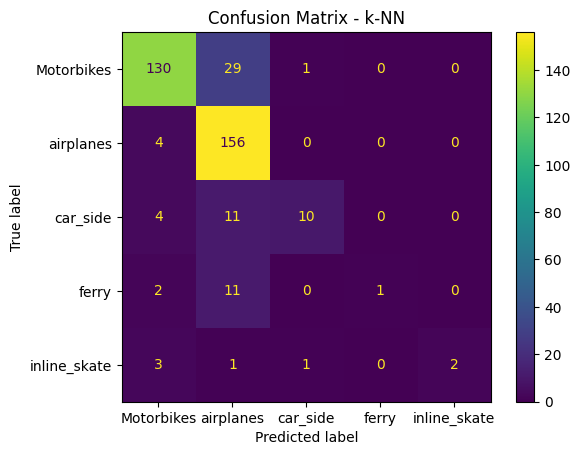

In [18]:
cm_knn = confusion_matrix(y_test, knn_preds)
disp_knn = ConfusionMatrixDisplay(cm_knn, display_labels=class_names)
disp_knn.plot()
plt.title("Confusion Matrix - k-NN")
plt.show()


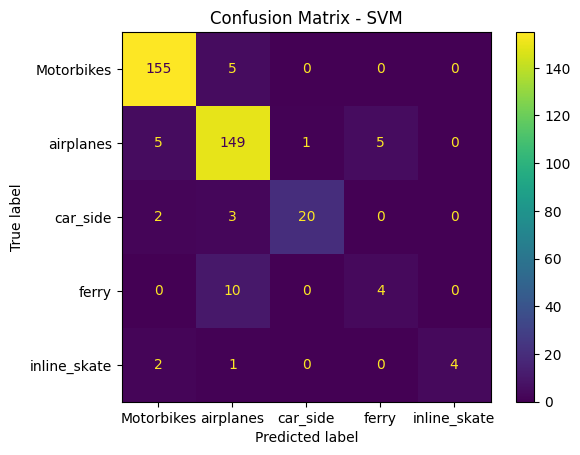

In [19]:
cm_svm = confusion_matrix(y_test, svm_preds)
disp_svm = ConfusionMatrixDisplay(cm_svm, display_labels=class_names)
disp_svm.plot()
plt.title("Confusion Matrix - SVM")
plt.show()


In [20]:
comparison = pd.DataFrame({
    "Μοντέλο": ["k-NN", "SVM"],
    "Accuracy": [knn_acc, svm_acc]
})

comparison


,Μοντέλο,Accuracy
0,k-NN,0.816940
1,SVM,0.907104


In [21]:
comparison.to_csv("experiment_4_final_comparison.csv", index=False)
print("✅ Αποθήκευση ολοκληρώθηκε: experiment_4_final_comparison.csv")


✅ Αποθήκευση ολοκληρώθηκε: experiment_4_final_comparison.csv


Στο πλαίσιο του Α’ Μέρους της εργασίας υλοποιήθηκε σύστημα αναγνώρισης εικόνων βασισμένο στο μοντέλο Bag of Visual Words (BOVW) με περιγραφείς SIFT. Μέσω πειραματικής αξιολόγησης διερευνήθηκαν οι παράμετροι K του λεξικού, k του ταξινομητή k-NN και C του SVM.

Τα αποτελέσματα έδειξαν ότι η βέλτιστη τιμή του λεξικού είναι K* = 400, ενώ για τον k-NN επιλέχθηκε k* = 3. Για το SVM, όλες οι τιμές του C παρήγαγαν ίδιο αποτέλεσμα και επιλέχθηκε η C* = 1 ως η πιο σταθερή επιλογή.

Στην τελική σύγκριση, το SVM πέτυχε ακρίβεια 90.71%, υπερτερώντας σημαντικά έναντι του k-NN, ο οποίος κατέγραψε ακρίβεια 81.69%. Συνεπώς, το SVM επιλέγεται ως το τελικό μοντέλο του Α’ Μέρους, καθώς παρουσιάζει σαφώς καλύτερη γενίκευση και σταθερότητα.»